# COMPLEX TASK WITH DEEPSEEK REASONER

In [1]:

# Core
import os
from openai import OpenAI
import re
import io
import logging
import sqlite3
from typing import TypedDict, List
# I/O and environment
from dotenv import load_dotenv, find_dotenv

import requests

In [2]:
from langgraph.graph import StateGraph, END
import sqlite3
from typing import TypedDict, List
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
memory = SqliteSaver(sqlite3.connect(":memory:", check_same_thread=False))

In [3]:
load_dotenv(find_dotenv())

True

In [4]:
# The TypeDict is imported from the typing module to define a type from dictionary with specific keys and values typed.

class AgentState(TypedDict):
    task: str
    plan: str
    calculator: str
    reviewer: str
    content: List[str]

In [5]:
# API configuration
API_URL = "https://api.deepseek.com/v1/chat/completions"

# get env DEEPSEEK_API_KEY
DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")
model = "deepseek-reasoner"

In [6]:
from openai import OpenAI

client = OpenAI(
    api_key = DEEPSEEK_API_KEY,
    base_url="https://api.deepseek.com"
)


# Headers configuration
"""headers = {
    "Authorization": f"Bearer {DEEPSEEK_API_KEY}",
    "Content-Type": "application/json"
}"""


def generate_response(messages):
    response = client.chat.completions.create(
        model= model,
        messages=messages,
        stream=False)
    
    return response.choices[0].message.content

In [7]:
PLAN_PROMPT = """
As an analyzer assistant, create a step-by-step plan to address complex user requests. Outline a clear, concise schema for task resolution. \
Prioritize logical flow, brevity, and actionable steps. \
Keep the response under 50 words
Give an answer clear, readable for humans and plain text.
"""

In [8]:
CALCULATOR_PROMPT = """
Your a helpful wise reasoning assistant. You are expert in thinking. As a precision calculator assistant, perform accurate calculations using optimal techniques. If the user provides feedback on your results, refine and improve your approach based on their input. Always reference and utilize the provided data:
------
{content}

Key Requirements:
    Deliver clear, step-by-step calculations.
    Adapt and enhance responses based on user feedback.
    Prioritize accuracy and methodological rigor
    Give an answer clear, readable for humans and plain text.
"""

In [9]:
REVIEWER_PROMPT = """
As a rigorous reviewer assistant, critically evaluate CALCULATOR_PROMPT's calculations. Provide concise yet detailed recommendations, highlighting errors, optimizations, and best-practice solutions. Prioritize accuracy and efficiency—deliver feedback in the fewest tokens possible without sacrificing clarity.
Key Improvements:
    Stronger Role Clarity – "Rigorous reviewer assistant" emphasizes precision.
    Actionable Focus – Explicitly calls for errors, optimizations, and best practices.
    Token Efficiency – Directly addresses brevity while maintaining detail.
    Removed Redundancy – Streamlined phrasing (e.g., "minimum tokens possible" → "fewest tokens possible").
    Give an answer clear, readable for humans and plain text.
"""

In [10]:
from pydantic import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [11]:
def plan_node(state: AgentState):
    messages = [
        {"role": "system", "content": PLAN_PROMPT},  
        {"role": "user", "content": state['task']} 
    ]
    response = generate_response(messages)
    plan = response.content if hasattr(response, 'content') else response
    return {"plan": plan}

In [12]:
def generation_node(state: AgentState):
    messages = [
        {"role": "system", "content": CALCULATOR_PROMPT},  
        {"role": "user", "content": state['plan']} 
    ]
    response = generate_response(messages)
    calculator = response.content if hasattr(response, 'content') else response
    return {"calculator": calculator}

In [13]:
def reflection_node(state: AgentState):
    messages = [
        {"role": "system", "content": REVIEWER_PROMPT},  
        {"role": "user", "content": state['calculator']} 
    ]
    response = generate_response(messages)
    reviewer = response.content if hasattr(response, 'content') else response
    
    return {"reviewer": reviewer}

In [14]:
def should_continue(state):
    if state["reflection"]:
        return END

In [15]:
builder = StateGraph(AgentState)

In [16]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflection", reflection_node)

In [17]:
builder.set_entry_point("planner")
builder.set_finish_point("reflection")  

In [18]:
builder.add_edge("planner", "generate")
builder.add_edge("generate", "reflection")

In [19]:
graph = builder.compile(checkpointer=memory)

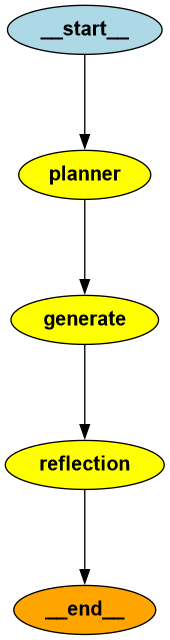

In [20]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [ ]:
from IPython.display import display, Markdown

# Simulación del stream y de las salidas
thread = {"configurable": {"thread_id": "1"}}

# Función para generar una salida más bonita
def print_pretty_output():
    for s in graph.stream({
        'task': "Calculate the area of a triangle with a base of 6 cm and a height of 4 cm.",
    }, thread):
        # Use the markdown for the final presentation
        display(Markdown(f"### Answer from the system: \n\n{s}"))

# Calling the function
print_pretty_output()

### Answer from the system: 

{'planner': {'plan': '1. **Identify formula**: Triangle area = (base × height) / 2.  \n2. **Plug values**: (6 cm × 4 cm) / 2.  \n3. **Calculate**: 24 cm² / 2 = **12 cm²**.  \n\n**Result**: Area = 12 cm².'}}

### Answer from the system: 

{'generate': {'calculator': '**Step-by-Step Calculation:**\n\n1. **Formula**: Area of a triangle = (base × height) / 2  \n2. **Substitute values**:  \n   - Base = 6 cm  \n   - Height = 4 cm  \n   Calculation: \\( \\frac{6 \\, \\text{cm} \\times 4 \\, \\text{cm}}{2} \\)  \n3. **Multiply base and height**:  \n   \\( 6 \\times 4 = 24 \\) → \\( 24 \\, \\text{cm}^2 \\)  \n4. **Divide by 2**:  \n   \\( \\frac{24 \\, \\text{cm}^2}{2} = 12 \\, \\text{cm}^2 \\)  \n\n**Result**: The area of the triangle is **12 cm²**.  \n\nThis method ensures accuracy by strictly following the formula and verifying unit consistency (cm × cm = cm²). Let me know if further clarification is needed!'}}

### Answer from the system: 

{'reflection': {'reviewer': '**Review:**  \n- ✅ **Accuracy:** Correct formula, steps, and units (cm²).  \n- ⚠️ **Optimization:** Combine operations: \\( \\frac{6}{2} \\times 4 = 12 \\, \\text{cm}^2 \\) (reduces steps).  \n- 📝 **Best Practices:**  \n  1. Explicitly state assumptions (e.g., height is perpendicular to base).  \n  2. Simplify notation: \\( \\frac{6 \\times 4}{2} \\) → \\( 3 \\times 4 \\).  \n- 📉 **Token Efficiency:** Remove redundant arrows (e.g., "24 → 24 cm²") by merging steps.  \n\n**Final Result:** Correct (12 cm²). Streamline for brevity without losing rigor.'}}